In [1]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    !pip install --no-deps xformers trl peft accelerate bitsandbytes transformers
pass

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-7b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.57G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

In [4]:
import pandas as pd
df = pd.read_csv('/content/Psych8k.csv')
df.head()

,Unnamed: 0,instruction,input,output,instructions
0,0,"If you are a counsellor, please answer the que...","Lately, I've been feeling really disconnected ...",Thank you for sharing your experience with me....,NaN
1,1,"If you are a counsellor, please answer the que...","Lately, I've been feeling really stressed and ...",Thank you for sharing your experience with me....,NaN
2,2,"If you are a counsellor, please answer the que...","Lately, I've been feeling a bit off. I sometim...",I appreciate you sharing your concerns with me...,NaN
3,3,"If you are a counsellor, please answer the que...","Lately, I've been feeling a bit off. I've noti...",Thank you for sharing your feelings and experi...,NaN
4,4,"If you are a counsellor, please answer the que...","Lately, I've been feeling quite off. I have be...",I appreciate you sharing your experiences with...,NaN


In [5]:
df=df.drop(['instructions'],axis=1)
df.head()

,Unnamed: 0,instruction,input,output
0,0,"If you are a counsellor, please answer the que...","Lately, I've been feeling really disconnected ...",Thank you for sharing your experience with me....
1,1,"If you are a counsellor, please answer the que...","Lately, I've been feeling really stressed and ...",Thank you for sharing your experience with me....
2,2,"If you are a counsellor, please answer the que...","Lately, I've been feeling a bit off. I sometim...",I appreciate you sharing your concerns with me...
3,3,"If you are a counsellor, please answer the que...","Lately, I've been feeling a bit off. I've noti...",Thank you for sharing your feelings and experi...
4,4,"If you are a counsellor, please answer the que...","Lately, I've been feeling quite off. I have be...",I appreciate you sharing your experiences with...


In [6]:
train_df = df.sample(n=7000)
test_df = df.drop(train_df.index)
from datasets import Dataset
training_data = Dataset.from_pandas(train_df)
testing_data = Dataset.from_pandas(test_df)

In [7]:
training_data = training_data.remove_columns(['__index_level_0__'])
testing_data = testing_data.remove_columns(['__index_level_0__'])

In [8]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


In [9]:
def apply_formatting(dataset):
    formatted_dataset = dataset.map(
        formatting_prompts_func,
        batched=True,
        num_proc=8
    )
    return formatted_dataset

In [10]:
final_train_dataset = apply_formatting(training_data)
final_test_dataset = apply_formatting(testing_data)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/7000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1187 [00:00<?, ? examples/s]

In [11]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",

    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,
    loftq_config = None, # And LoftQ
)

Unsloth 2024.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [12]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = final_train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 250,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 25,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/7000 [00:00<?, ? examples/s]

In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 7,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 250
 "-____-"     Number of trainable parameters = 50,003,968


Step,Training Loss
25,1.353600
50,1.115600
75,1.128500
100,1.096500
125,1.089200
150,1.088700
175,1.086000
200,1.071400
225,1.097500
250,1.077500


In [16]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "If you are a counsellor, please answer the questions based on the description of the patient.", # instruction
        "I was with a girl one time and we got back to my place. She said she was going to go to the doctor, and everything seemed resolved, but the police were there and I got arrested. I was charged with kidnapping and some other stuff, and I ended up serving some time.", # input
        "",
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 350)

<bos>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
If you are a counsellor, please answer the questions based on the description of the patient.

### Input:
I was with a girl one time and we got back to my place. She said she was going to go to the doctor, and everything seemed resolved, but the police were there and I got arrested. I was charged with kidnapping and some other stuff, and I ended up serving some time.

### Response:
It sounds like you went through a difficult situation and ended up serving time in prison. Can you tell me more about how this experience has affected you and what you've learned from it?<eos>


In [17]:
FastLanguageModel.for_inference(model) # Enabling native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "If you are a counsellor, please answer the questions based on the description of the patient.", # instruction
        "I don't like to talk about this, but I'm afraid that my partner secretly agrees with my belief that unless I'm skinny, I'm not attractive or worthy enough. I think all guys think that way and I believe my partner should love me regardless of my weight.", # input
        "",
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 350)

<bos>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
If you are a counsellor, please answer the questions based on the description of the patient.

### Input:
I don't like to talk about this, but I'm afraid that my partner secretly agrees with my belief that unless I'm skinny, I'm not attractive or worthy enough. I think all guys think that way and I believe my partner should love me regardless of my weight.

### Response:
It's understandable that you're concerned about your partner's thoughts and feelings about your weight. It's important to communicate your feelings and beliefs with your partner to understand their perspective. Have you tried discussing this with your partner to see if they share your beliefs or if they have a different perspective on your worth and attractiveness?<eos>


In [18]:
pdf = pd.DataFrame(trainer.state.log_history)
csv_file = "finetuned_model.csv"
pdf.to_csv(csv_file,index=False)

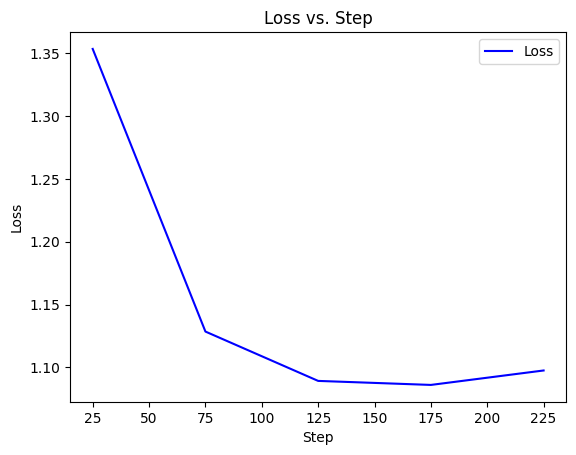

In [20]:
import matplotlib.pyplot as plt
import numpy as np
loss_values = np.array(pdf.loc[:18:2, 'loss'].values)
steps = np.array(pdf.loc[:18:2, 'step'].values)

# Plot the data
plt.plot(steps, loss_values, color='blue', label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.savefig('Gemma Finetuning History')
plt.title('Loss vs. Step')
plt.legend()
plt.show()

In [23]:
trainer.save_model('/content/gemma_finetuned')

In [24]:
from huggingface_hub import HfApi
from google.colab import userdata
api = HfApi()
api.upload_folder(
    folder_path="/content/gemma_finetuned",
    repo_id="PrahmodhRaj/Gemma-7B_Psychiatrist_Chat",
    repo_type="model",
    use_auth_token = userdata.get("Huggingface")
)

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/PrahmodhRaj/Gemma-7B_Psychiatrist_Chat/commit/e3a90250a602ac5b23dd4060813de6a39f890cc1', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e3a90250a602ac5b23dd4060813de6a39f890cc1', pr_url=None, pr_revision=None, pr_num=None)